<a href="https://colab.research.google.com/github/JunjieLiang-Jack/Audio-Classifier/blob/main/7_cnn_model_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Classifying audio data with convolutional neural networks

<br/>
by Eduardo Garcia Rajo<br/>
<br/>

This notebook is part of the project "Urban sounds classification with Covnolutional Neural Networks" on [my Github](https://github.com/GorillaBus/urban-audio-classifier).<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

# Training CNN model with augmented data

We are now able to train our basic -but yet well performing- CNN architecture with the new augmented data. While the initial dataset had 8,732 samples, the augmented dataset has 69,856, that is 8x more information than previous experiments.<br/>
We'll use Log-Mel Spectrograms as features because they showed to perform better than MFCC in our experiments.<br/>
<br/>
As an important note, we are going to train from augmented data but we are only going to test with samples from the original dataset: we want to know how the augmented data helps to improve predictions of the original data.<br/>
<br/>

#### * Load required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/GorillaBus/urban-audio-classifier.git


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'urban-audio-classifier' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.insert(0,'/content/urban-audio-classifier/include')
import helpers

In [ ]:
!pip install np_utils

In [ ]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime


from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

In [ ]:
# Set your path to the dataset
us8k_path = os.path.abspath('drive/MyDrive/CNN/Training\ Data/UrbanSound8K/')
orig_metadata_path = os.path.abspath('drive/MyDrive/CNN/Training Data/UrbanSound8K/metadata/UrbanSound8K.csv')
aug_metadata_path = os.path.abspath('drive/MyDrive/CNN/Training Data/UrbanSound8K/metadata/augmented-data.csv')
models_path = os.path.abspath('drive/MyDrive/CNN/Training Data/UrbanSound8K/models')
data_path = os.path.abspath('./data')
audio_path = os.path.join(us8k_path, 'audio')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [ ]:
# Required for the RTX GPU -- uncomment if using GTX or CPU
import keras.backend as K
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.compat.v1.Session(config=config)) 

#### * Load data

In [ ]:
# Pre-processed MEL SPEC coefficients
X = np.load('drive/MyDrive/CNN/Training Data/UrbanSound8K/data/mel_spec/X-mel_spec-augmented.npy')
y = np.load('drive/MyDrive/CNN/Training Data/UrbanSound8K/data/mel_spec/y-mel_spec-augmented.npy')


# Metadata
metadata = pd.read_csv(orig_metadata_path)
aug_metadata = pd.read_csv(aug_metadata_path)

OSError: ignored

In [ ]:
print(X.shape)

(69856, 40, 174)


### 1. Data preparation: features + metadata

#### 1.1 Train / Test split

We are doing split data with the mentioned criteria in an extremely simple fashion: splitting 20% of the augmented dataset into test and then removing all reference to augmented samples from it. We'll end up with an amount of test data that will always be around 1700+ samples.<br/>
<br/>

In [ ]:
indexes = []
total = len(aug_metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

# Split metadata
test_meta = aug_metadata.iloc[test_split_idx]
train_meta = aug_metadata.iloc[train_split_idx]

#print(len(test_split_idx))
#print(len(train_split_idx))

# Remove augmented data from test metadata split
test_meta = test_meta[test_meta['augment'] != 'none']
aug_on_test_idx = test_meta.index.tolist()

print(len(test_meta))
print(len(aug_on_test_idx))

# Split the features with the same indexes
X_test = np.take(X, aug_on_test_idx, axis=0)
y_test = np.take(y, aug_on_test_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)
print(X_test.shape)
print(X.shape)

# Print status
#print("Test split: {} \t\t Train split: {}".format(len(test_meta)-len(aug_on_test_idx), len(train_meta)))
#print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
#print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))


NameError: ignored

#### 1.2 One hot encode labels

In [ ]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.3 Reshape data

In [ ]:
# How data should be organized
num_rows = 40
num_columns = 174
num_channels = 1

# Reshape to fit the network input (channel last!)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

print(X_test.shape)
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]


(12206, 40, 174, 1)


### 2. Basic CNN model

We are using the exact same model than the previous notebooks

#### 2.1 Model definition

In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())

    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.001

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

#### 2.2 Setup model optimizer and loss function

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### 2.3 Compile model

In [ ]:
num_epochs = 48
num_batch_size = 128
model_file = 'aug-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start

print("Training completed in time: ", duration)

Epoch 1/48
401/401 [==============================] - 34s 80ms/step - loss: 1.6090 - accuracy: 0.4957 - val_loss: 1.5022 - val_accuracy: 0.5425

Epoch 00001: val_loss improved from inf to 1.50225, saving model to /content/drive/MyDrive/CNN/Training\ Data/UrbanSound8K/models/aug-train-nb3.hdf5
Epoch 2/48
401/401 [==============================] - 30s 75ms/step - loss: 1.4076 - accuracy: 0.5642 - val_loss: 1.2041 - val_accuracy: 0.6436

Epoch 00002: val_loss improved from 1.50225 to 1.20409, saving model to /content/drive/MyDrive/CNN/Training\ Data/UrbanSound8K/models/aug-train-nb3.hdf5
Epoch 3/48
401/401 [==============================] - 30s 75ms/step - loss: 1.2770 - accuracy: 0.6080 - val_loss: 1.0939 - val_accuracy: 0.7108

Epoch 00003: val_loss improved from 1.20409 to 1.09387, saving model to /content/drive/MyDrive/CNN/Training\ Data/UrbanSound8K/models/aug-train-nb3.hdf5
Epoch 4/48
401/401 [==============================] - 30s 75ms/step - loss: 1.1865 - accuracy: 0.6446 - val_lo

#### 2.4 General model evaluation

In [ ]:

model.save('drive/MyDrive/CNN/Training Data/UrbanSound8K/models/aug-train-nb3.hdf5')

# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.2547       94.7285
Test:             0.2643       94.5227
Normal diff          3.62 


With a normal error difference of **3.75** between test and train we seem to have found a sweet spot, just before it starts overfitting, with an awesome accuracy improvement compared to all previous experiments, reaching **~95%** in test. The error has been minimized as much as **~0.22**.

#### 2.5 Train vs Test history plot

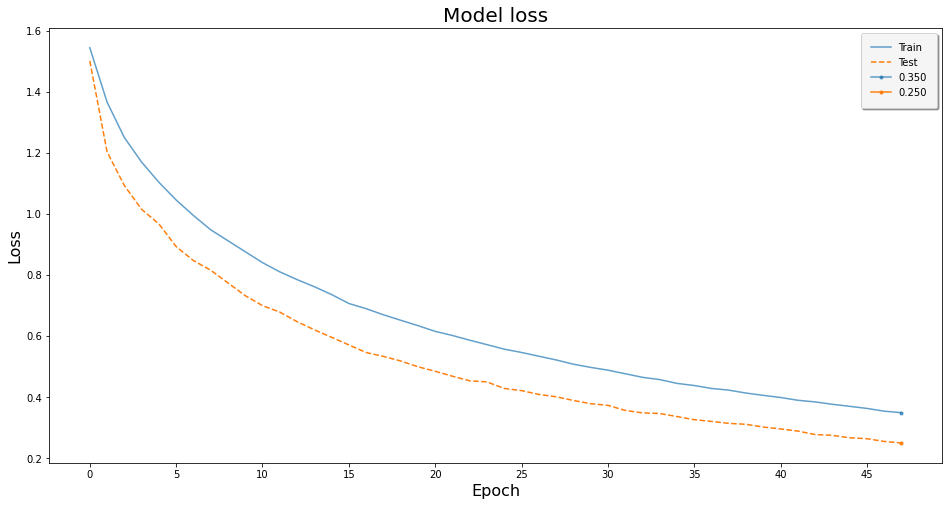

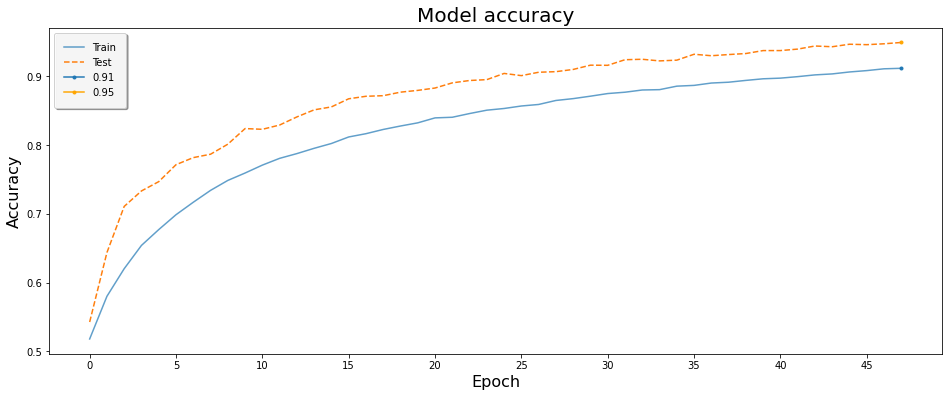

In [ ]:
helpers.plot_train_history(history)

Training dynamics have changed in comparison to the last two experiments where the validation error reached a maximum value during the first few epochs before starting to minimize and becoming comparable with train loss. In this case the validation loss minimized since the first epoch, as we have more data representing what we want to predict. Generalization gap is noticeable by two smooth loss lines and the error difference looks quite the same than last experiment with Log-Mel Spectrograms.<br/>
<br/>

### 3. Model evaluation

#### * Register model output

In [ ]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

NameError: ignored

#### 3.1 Confusion matrix

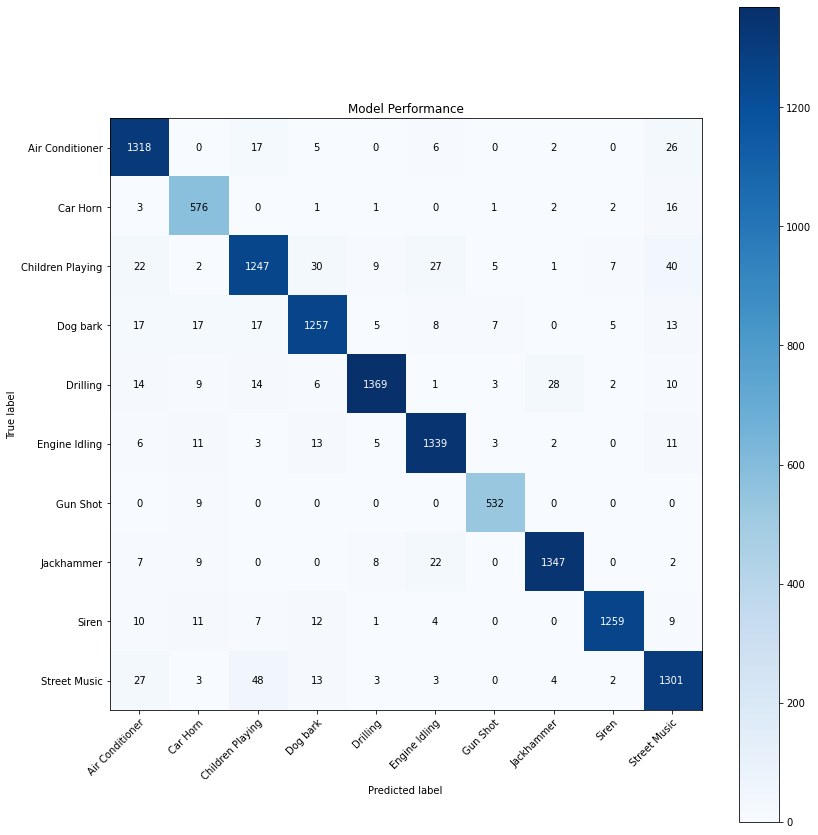

In [ ]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

We now have multiple times more data than before in our test set but still we can see how some particular patterns are still present, hopefully, with a slighter effect. Usual misclassification cases still happen between **Street Music** and **Children Playing**, **Drilling** and **Jack Hammer** or **Dog Bark** and **Children Playing**.

#### 3.2 Accuracy table

In [ ]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,98.336414
7,Jackhammer,96.559140
5,Engine Idling,96.123475
0,Air Conditioner,95.924309
8,Siren,95.887281
1,Car Horn,95.681063
4,Drilling,94.024725
3,Dog bark,93.387816
9,Street Music,92.663818
2,Children Playing,89.712230


Happily, every class accuracy has raised! What's more interesting is that results are more balanced between classes now.<br/>

In [ ]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.93      0.96      0.94      1374
        Car Horn       0.89      0.96      0.92       602
Children Playing       0.92      0.90      0.91      1390
        Dog bark       0.94      0.93      0.94      1346
        Drilling       0.98      0.94      0.96      1456
   Engine Idling       0.95      0.96      0.96      1393
        Gun Shot       0.97      0.98      0.97       541
      Jackhammer       0.97      0.97      0.97      1395
           Siren       0.99      0.96      0.97      1313
    Street Music       0.91      0.93      0.92      1404

        accuracy                           0.95     12214
       macro avg       0.94      0.95      0.95     12214
    weighted avg       0.95      0.95      0.95     12214



Similar to class accuracies, we see an increase in the average F1, Precision and Recall scores, and also, more balanced results. The common patterns we have been seeing for the last two experiments are still present but with a much slighter effect.<br/>
<br/>

## 4. Conclusion

All along this experiments we have learned how a very simple convolutional neural network can learn to recognize audible events, even when working with quite unbalanced datasets as the UrbanSound8K is. I would still like to experiment with different feature combinations; not that this performance scores are useless, we sure can use this model as it is to learn simple events like orders ("start", "right", "update", "stop", ...) or numbers for example.<br/>
<br/>
The amount of data showed to be a very important factor, until data augmentation training results where much more bound to the distribution of train/test splits: where it was easy to end up with a test split that wouldn't represent the train split. This didn't happen with augmented data.<br/>
<br/>
